In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import keras_cnn
from algorithms.ind_optimized_search import IndependentOptimizedSearch

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
input_shape = (28, 28, 1)
num_outputs = 10
num_kernels = 32
num_stages = 7
path_trained_weights = 'C:/Users/320060820/experiments/test_models/fashion_keras/fashion_seq_large_w.h5'
name = 'fashion_seq_large'

from test_models.fashion_keras import data
_, test_data = data.get_data()

model_arch = keras_cnn.KerasCNNLarge(input_shape, num_outputs, num_kernels, num_stages, pool_layer_interval = 2, 
                                     path_trained_weights = path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0.9247


### Weights

In [3]:
layer_names = []

for layer in model_obj.model.layers:
    if layer.name.startswith('conv2d') or layer.name.startswith('dense'):
        layer_names.append(layer.name)

In [5]:
# weights
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
w_scores, opt_params_weights, acc_drop_w = opts.run('weights', start_bw = 8)
opt_params_weights

{'conv2d_1': [8, 8], 'conv2d_2': [8, 9], 'conv2d_3': [8, 9], 'conv2d_4': [8, 9], 'conv2d_5': [8, 9], 'conv2d_6': [8, 9], 'conv2d_7': [8, 9], 'conv2d_8': [8, 10], 'conv2d_9': [8, 9], 'conv2d_10': [8, 9], 'conv2d_11': [8, 10], 'conv2d_12': [8, 9], 'conv2d_13': [8, 9], 'conv2d_14': [8, 9], 'dense_1': [8, 8]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (6, 7) Local opt: (6, 7) Performance diff: 0.000000
Chosen:  (6, 7)
After quantizing layer conv2d_1 | Measured accuracy drop 0.000108 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_2
Global opt: (3, 5) Local opt: (4, 6) Performance diff: 0.002920
Chosen:  (4, 6)
After quantizing layer conv2d_2 | Measured accuracy drop 0.002704 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (3, 4) Local opt: (4, 5) Performance diff: 0.001190
Chosen:  (3, 4)
After quantizing layer conv2d_3 | Measured accuracy drop 0.005083 | Acceptable accuracy drop: 0.003000


{'conv2d_1': (6, 7),
 'conv2d_2': (4, 6),
 'conv2d_3': (3, 4),
 'conv2d_4': (4, 6),
 'conv2d_5': (3, 4),
 'conv2d_6': (3, 5),
 'conv2d_7': (3, 4),
 'conv2d_8': (2, 4),
 'conv2d_9': (3, 5),
 'conv2d_10': (3, 5),
 'conv2d_11': (3, 5),
 'conv2d_12': (4, 6),
 'conv2d_13': (2, 4),
 'conv2d_14': (2, 4),
 'dense_1': (2, 2)}

Floating point model accuracy: 92.470 %
Quantized model accuracy: 90.050 %
Accuracy drop of 2.617 %


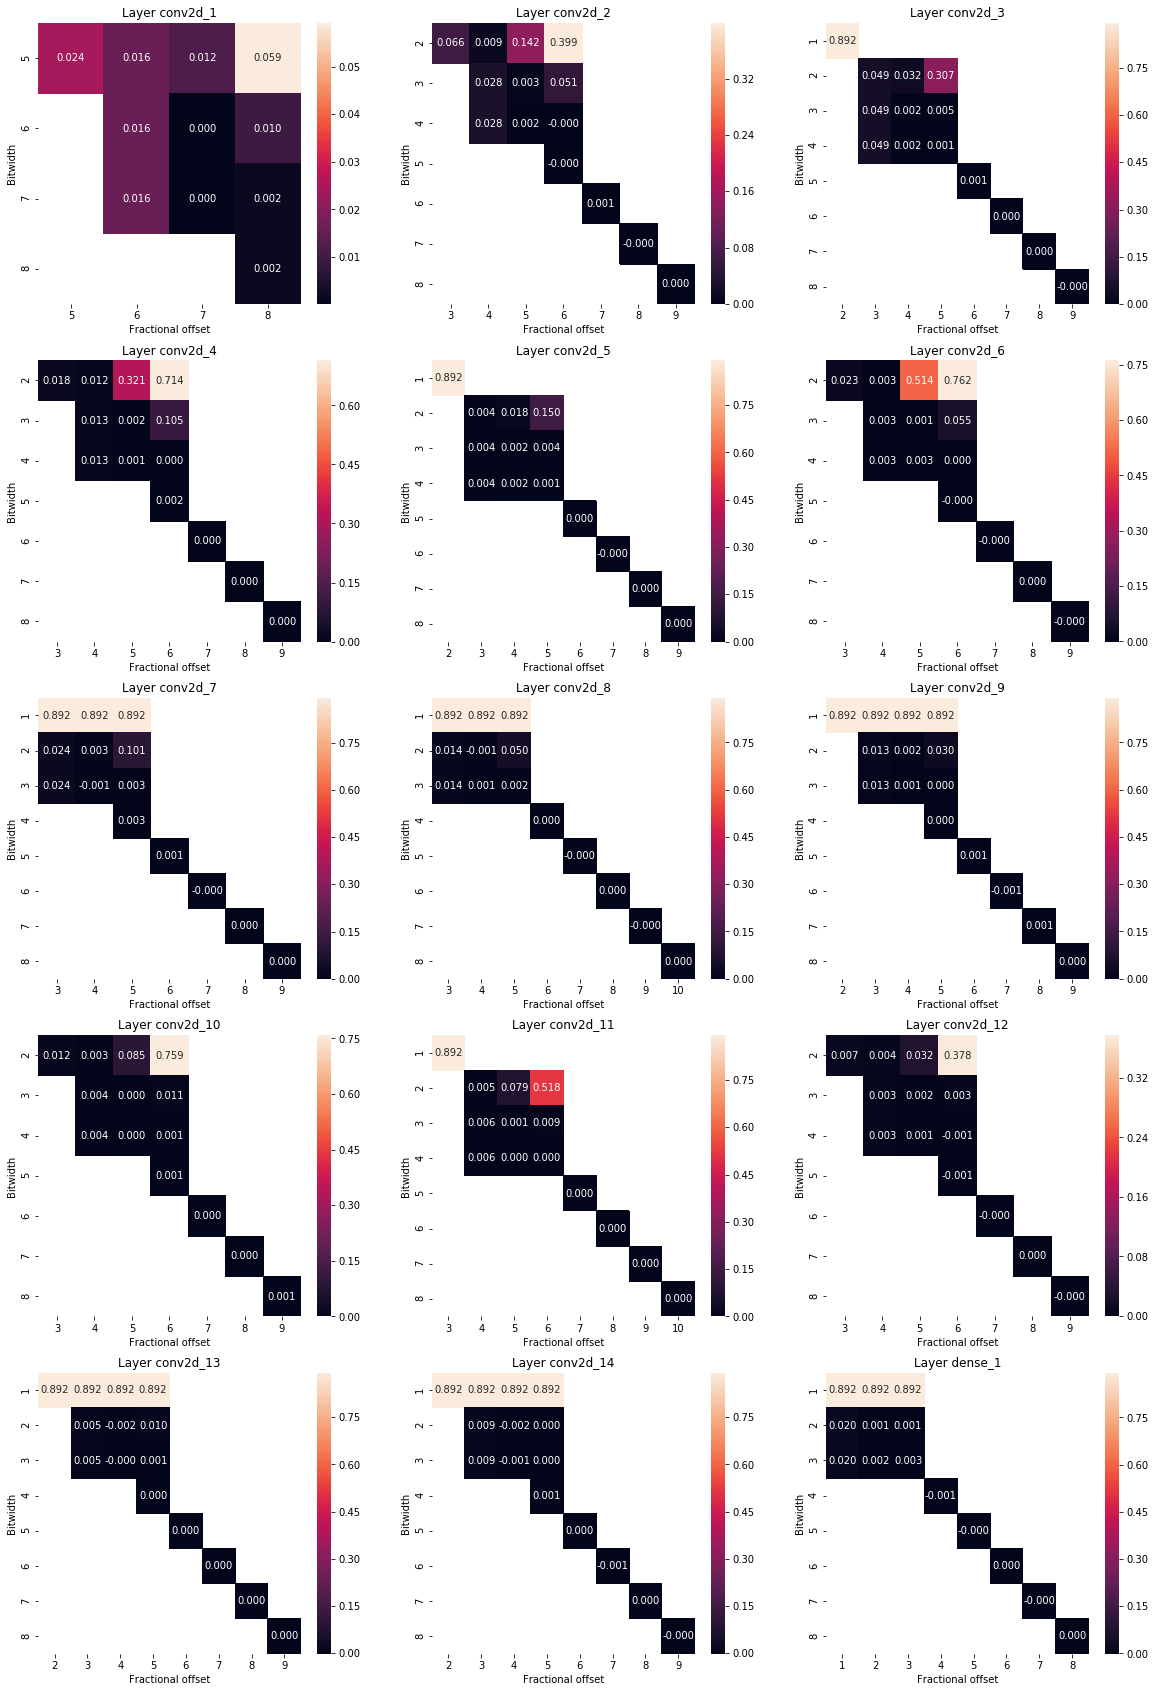

In [7]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(w_scores, 5, 3, (20, 30))

In [8]:
for layer in w_scores:
    print(layer)
    print(f'Layer {layer} acc drop: {w_scores[layer][opt_params_weights[layer][0]][opt_params_weights[layer][1]]:.5f}')

conv2d_1
Layer conv2d_1 acc drop: 0.00011
conv2d_2
Layer conv2d_2 acc drop: -0.00022
conv2d_3
Layer conv2d_3 acc drop: 0.00173
conv2d_4
Layer conv2d_4 acc drop: 0.00043
conv2d_5
Layer conv2d_5 acc drop: 0.00238
conv2d_6
Layer conv2d_6 acc drop: 0.00076
conv2d_7
Layer conv2d_7 acc drop: -0.00065
conv2d_8
Layer conv2d_8 acc drop: -0.00087
conv2d_9
Layer conv2d_9 acc drop: 0.00000
conv2d_10
Layer conv2d_10 acc drop: 0.00000
conv2d_11
Layer conv2d_11 acc drop: 0.00097
conv2d_12
Layer conv2d_12 acc drop: -0.00087
conv2d_13
Layer conv2d_13 acc drop: -0.00173
conv2d_14
Layer conv2d_14 acc drop: -0.00205
dense_1
Layer dense_1 acc drop: 0.00087


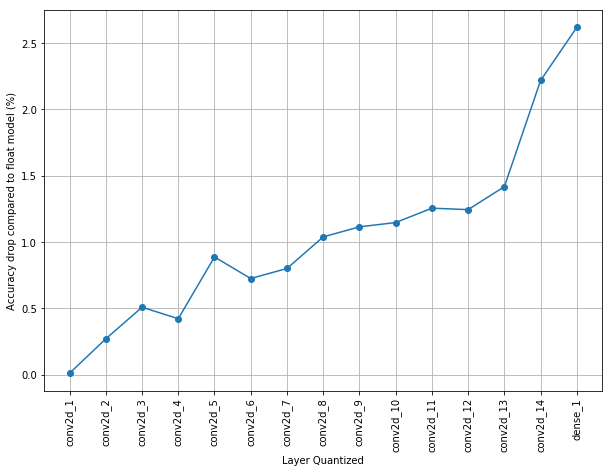

In [9]:
x = np.arange(1, len(acc_drop_w.values()) + 1, 1)
y = np.array(list(acc_drop_w.values())) * 100
labels = list(acc_drop_w.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

In [10]:
import pickle

save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/Keras Fashion/'

with open(save_path + 'scores_w.p', 'wb') as f:
    pickle.dump(w_scores, f)
with open(save_path + 'opt_params_w.p', 'wb') as f:
    pickle.dump(opt_params_weights, f)
with open(save_path + 'acc_drop_w.p', 'wb') as f:
    pickle.dump(acc_drop_w, f)

### Biases

In [4]:
# biases
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
b_scores, opt_params_biases, acc_drop_b = opts.run('biases', start_bw = 8)
opt_params_biases

{'conv2d_1': [8, 11], 'conv2d_2': [8, 11], 'conv2d_3': [8, 11], 'conv2d_4': [8, 10], 'conv2d_5': [8, 10], 'conv2d_6': [8, 11], 'conv2d_7': [8, 11], 'conv2d_8': [8, 11], 'conv2d_9': [8, 11], 'conv2d_10': [8, 11], 'conv2d_11': [8, 11], 'conv2d_12': [8, 10], 'conv2d_13': [8, 11], 'conv2d_14': [8, 10], 'dense_1': [8, 10]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (4, 7) Local opt: (4, 7) Performance diff: 0.000000
Chosen:  (4, 7)
After quantizing layer conv2d_1 | Measured accuracy drop 0.000649 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_2
Global opt: (1, 4) Local opt: (2, 5) Performance diff: 0.000324
Chosen:  (1, 4)
After quantizing layer conv2d_2 | Measured accuracy drop 0.000973 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (1, 4) Local opt: (1, 3) Performance diff: 0.000000
Chosen:  (1, 3)
After quantizing layer conv2d_3 | Measured accuracy drop 0.001190 | Acceptable accuracy dr

{'conv2d_1': (4, 7),
 'conv2d_2': (1, 4),
 'conv2d_3': (1, 3),
 'conv2d_4': (1, 3),
 'conv2d_5': (1, 3),
 'conv2d_6': (1, 3),
 'conv2d_7': (1, 4),
 'conv2d_8': (1, 4),
 'conv2d_9': (1, 4),
 'conv2d_10': (1, 4),
 'conv2d_11': (1, 4),
 'conv2d_12': (1, 2),
 'conv2d_13': (1, 4),
 'conv2d_14': (1, 2),
 'dense_1': (1, 2)}

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.400 %
Accuracy drop of 0.076 %


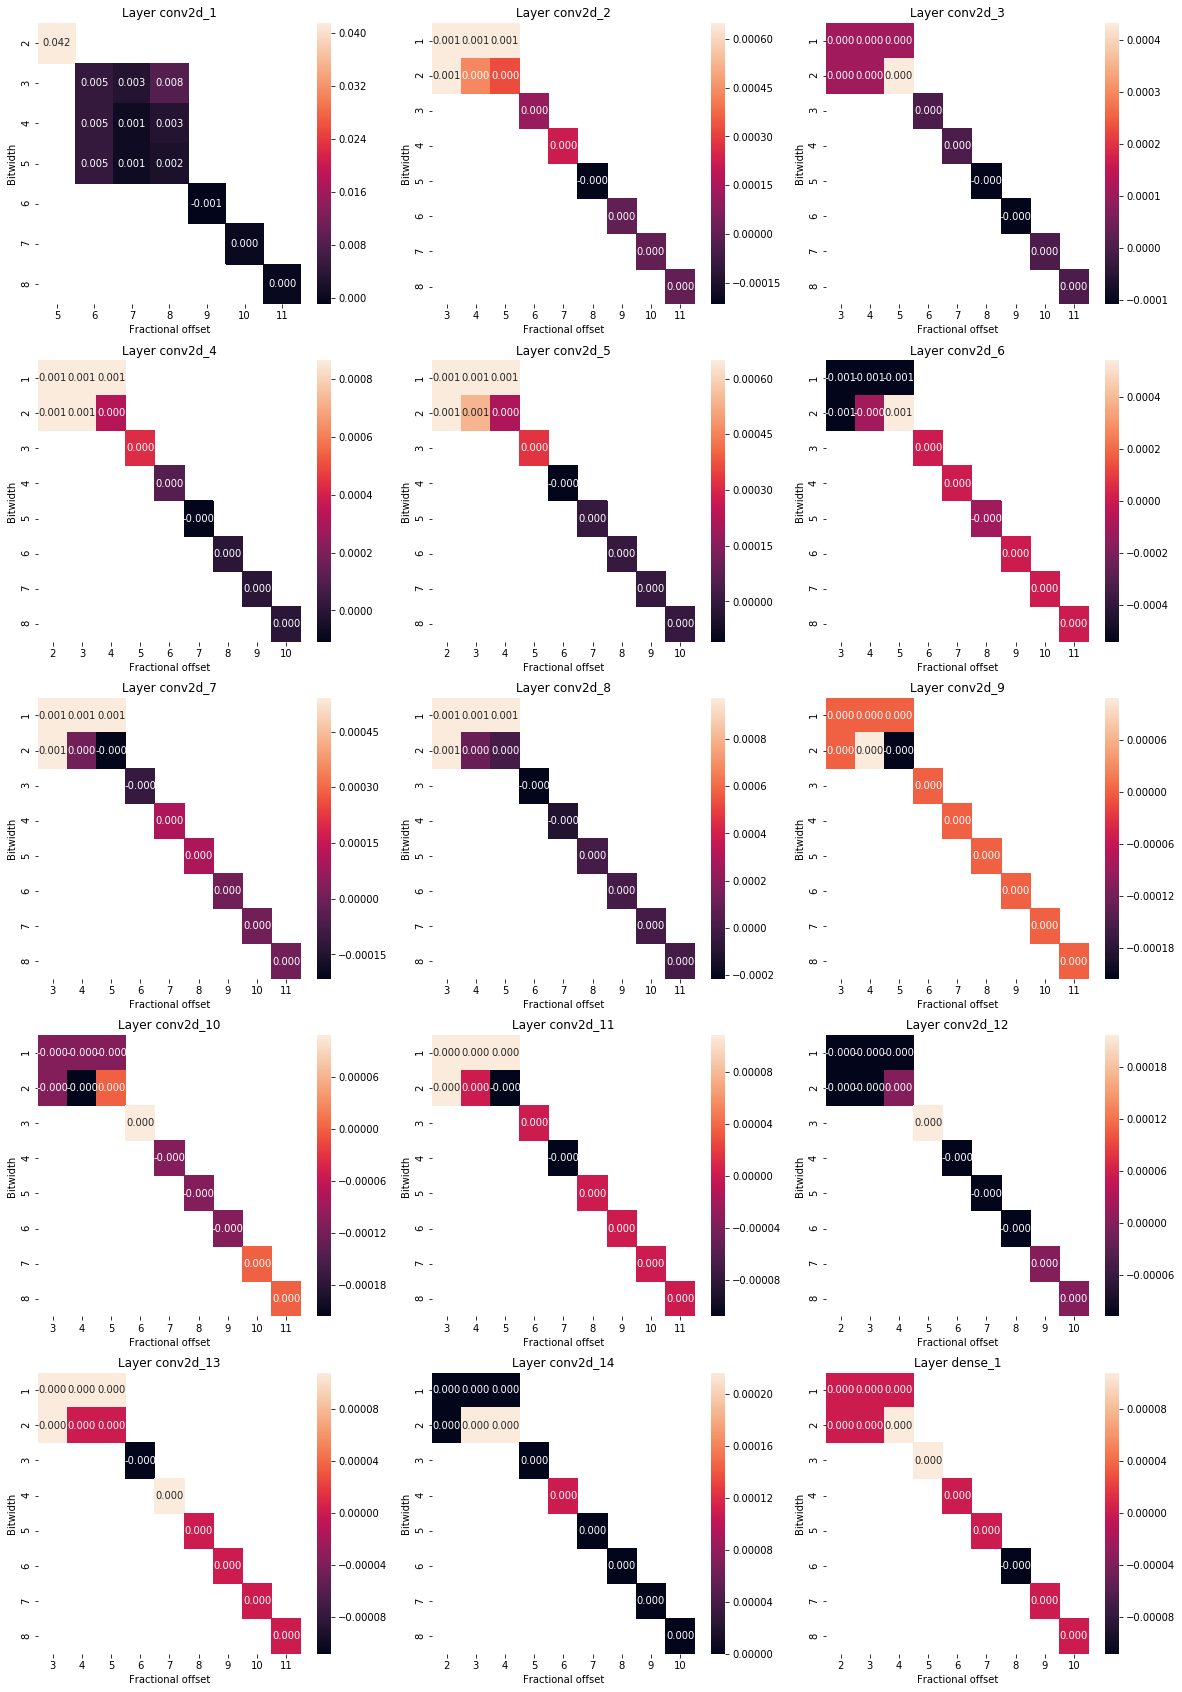

In [5]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_biases_quantization(model_obj, opt_params_biases)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(b_scores, 5, 3, (20, 30))

In [6]:
for layer in b_scores:
    print(f'Layer {layer} acc drop: {b_scores[layer][opt_params_biases[layer][0]][opt_params_biases[layer][1]]:.5f}')

Layer conv2d_1 acc drop: 0.00065
Layer conv2d_2 acc drop: 0.00065
Layer conv2d_3 acc drop: 0.00011
Layer conv2d_4 acc drop: 0.00087
Layer conv2d_5 acc drop: 0.00065
Layer conv2d_6 acc drop: -0.00054
Layer conv2d_7 acc drop: 0.00054
Layer conv2d_8 acc drop: 0.00097
Layer conv2d_9 acc drop: 0.00000
Layer conv2d_10 acc drop: -0.00011
Layer conv2d_11 acc drop: 0.00011
Layer conv2d_12 acc drop: -0.00011
Layer conv2d_13 acc drop: 0.00011
Layer conv2d_14 acc drop: 0.00000
Layer dense_1 acc drop: 0.00000


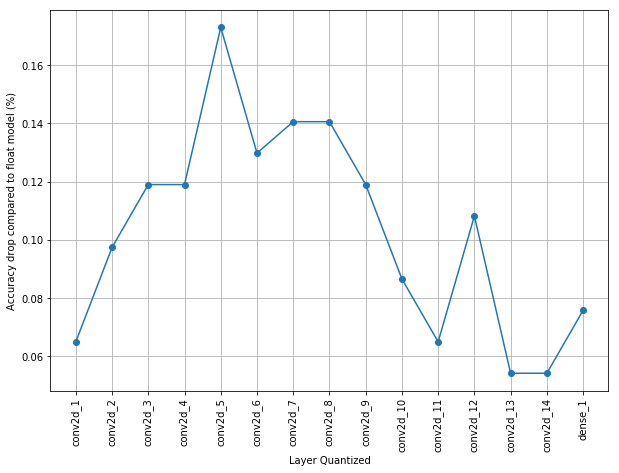

In [7]:
x = np.arange(1, len(acc_drop_b.values()) + 1, 1)
y = np.array(list(acc_drop_b.values())) * 100
labels = list(acc_drop_b.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

### Activations

In [8]:
# activations
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
a_scores, opt_params_act, acc_drop_a = opts.run('activations', start_bw = 8)
opt_params_act

{'conv2d_1': [8, 7], 'conv2d_2': [8, 4], 'conv2d_3': [8, 3], 'conv2d_4': [8, 4], 'conv2d_5': [8, 3], 'conv2d_6': [8, 3], 'conv2d_7': [8, 4], 'conv2d_8': [8, 3], 'conv2d_9': [8, 3], 'conv2d_10': [8, 3], 'conv2d_11': [8, 3], 'conv2d_12': [8, 2], 'conv2d_13': [8, 2], 'conv2d_14': [8, 2], 'dense_1': [8, 2]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (6, 6) Local opt: (7, 7) Performance diff: 0.001622
Chosen:  (7, 7)
After quantizing layer conv2d_1 | Measured accuracy drop 0.000000 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_2
Global opt: (6, 3) Local opt: (7, 4) Performance diff: 0.000433
Chosen:  (6, 3)
After quantizing layer conv2d_2 | Measured accuracy drop 0.002595 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (4, 1) Local opt: (5, 2) Performance diff: 0.001514
Chosen:  (5, 2)
After quantizing layer conv2d_3 | Measured accuracy drop 0.001730 | Acceptable accuracy drop: 0.003000
Qu

{'conv2d_1': (7, 7),
 'conv2d_2': (6, 3),
 'conv2d_3': (5, 2),
 'conv2d_4': (3, 0),
 'conv2d_5': (4, 0),
 'conv2d_6': (4, 1),
 'conv2d_7': (3, 0),
 'conv2d_8': (3, 0),
 'conv2d_9': (3, -1),
 'conv2d_10': (4, 1),
 'conv2d_11': (4, 1),
 'conv2d_12': (2, -1),
 'conv2d_13': (3, -1),
 'conv2d_14': (4, 1),
 'dense_1': (6, 1)}

Floating point model accuracy: 92.470 %
Quantized model accuracy: 91.150 %
Accuracy drop of 1.427 %


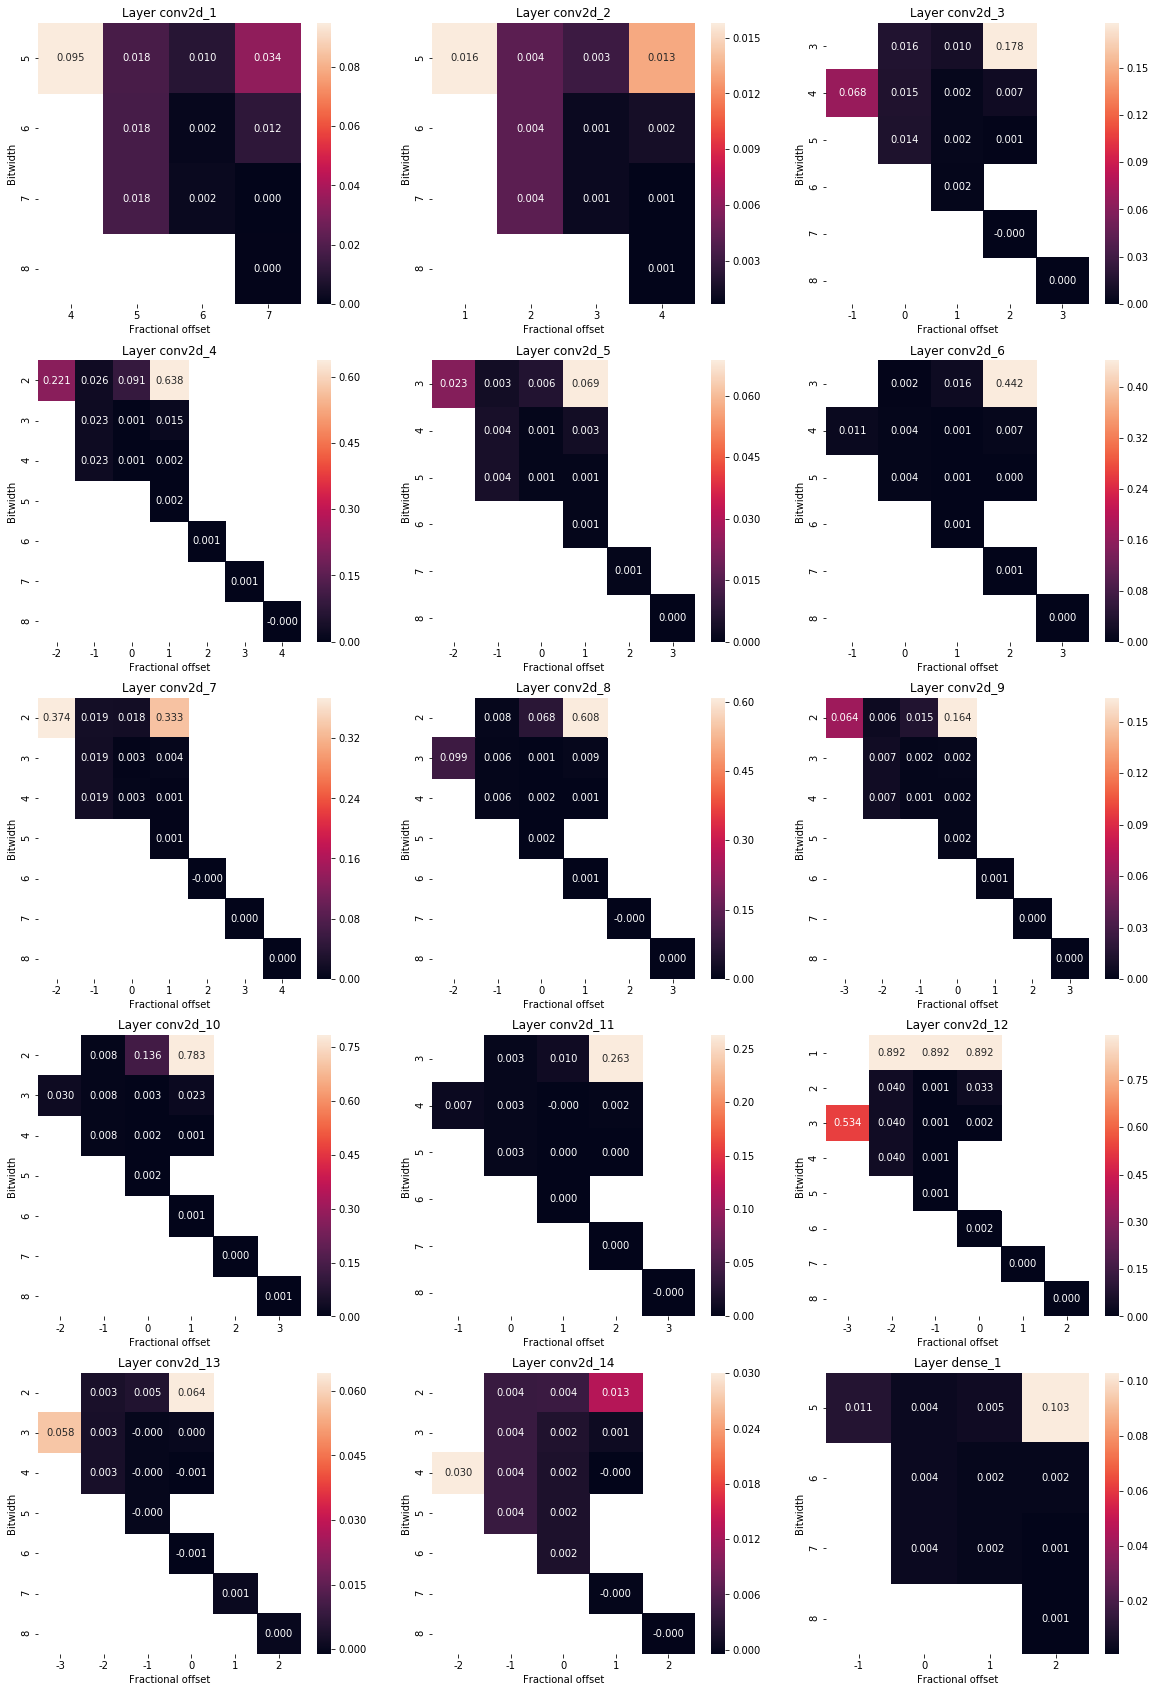

In [9]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act))
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(a_scores, 5, 3, (20, 30))

In [10]:
for layer in a_scores:
    print(f'Layer {layer} acc drop: {a_scores[layer][opt_params_act[layer][0]][opt_params_act[layer][1]]:.5f}')

Layer conv2d_1 acc drop: 0.00000
Layer conv2d_2 acc drop: 0.00108
Layer conv2d_3 acc drop: 0.00076
Layer conv2d_4 acc drop: 0.00097
Layer conv2d_5 acc drop: 0.00076
Layer conv2d_6 acc drop: 0.00130
Layer conv2d_7 acc drop: 0.00260
Layer conv2d_8 acc drop: 0.00087
Layer conv2d_9 acc drop: 0.00151
Layer conv2d_10 acc drop: 0.00108
Layer conv2d_11 acc drop: -0.00011
Layer conv2d_12 acc drop: 0.00087
Layer conv2d_13 acc drop: -0.00011
Layer conv2d_14 acc drop: -0.00043
Layer dense_1 acc drop: 0.00195


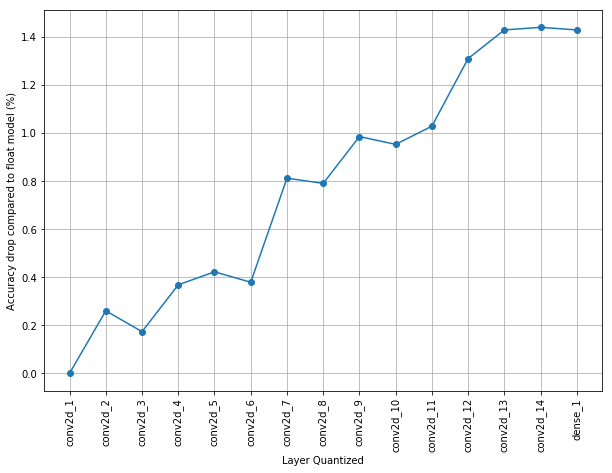

In [11]:
x = np.arange(1, len(acc_drop_a.values()) + 1, 1)
y = np.array(list(acc_drop_a.values())) * 100
labels = list(acc_drop_a.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

In [12]:
import pickle
save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/Keras Fashion/'

In [13]:
with open(save_path + 'opt_params_w.p', 'rb') as f:
    opt_params_weights = pickle.load(f)

In [14]:
def quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params={}, a_quant_params={}):
    
    if a_quant_params:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_fxp_model(a_quant_params))
    else:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_float_model())
    
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, w_quant_params)
    if b_quant_params:
        model_obj = fxp_quantize.fix_biases_quantization(model_obj, b_quant_params)
    
    return (float_model_acc - model_obj.evaluate_accuracy()[1]) / float_model_acc

In [15]:
def evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, a_quant_params):
    
    acc_drop_b = {}
    for i in range(1, len(list(b_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(b_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, test_case)
        acc_drop_b[list(test_case.keys())[-1]] = a
        print(acc_drop_b)

    acc_drop_a = {}
    for i in range(1, len(list(a_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(a_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, test_case)
        acc_drop_a[list(test_case.keys())[-1]] = a
        print(acc_drop_a)
        
    return acc_drop_b, acc_drop_a  

In [16]:
acc_drop_b, acc_drop_a = evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, opt_params_weights, 
                                            opt_params_biases,
                                            opt_params_act)

{'conv2d_1': 0.02757651130096244}
{'conv2d_1': 0.02757651130096244, 'conv2d_2': 0.026170649940521252}
{'conv2d_1': 0.02757651130096244, 'conv2d_2': 0.026170649940521252, 'conv2d_3': 0.02692765221152798}
{'conv2d_1': 0.02757651130096244, 'conv2d_2': 0.026170649940521252, 'conv2d_3': 0.02692765221152798, 'conv2d_4': 0.02681950902995559}
{'conv2d_1': 0.02757651130096244, 'conv2d_2': 0.026170649940521252, 'conv2d_3': 0.02692765221152798, 'conv2d_4': 0.02681950902995559, 'conv2d_5': 0.02714393857467288}
{'conv2d_1': 0.02757651130096244, 'conv2d_2': 0.026170649940521252, 'conv2d_3': 0.02692765221152798, 'conv2d_4': 0.02681950902995559, 'conv2d_5': 0.02714393857467288, 'conv2d_6': 0.0282253703903969}
{'conv2d_1': 0.02757651130096244, 'conv2d_2': 0.026170649940521252, 'conv2d_3': 0.02692765221152798, 'conv2d_4': 0.02681950902995559, 'conv2d_5': 0.02714393857467288, 'conv2d_6': 0.0282253703903969, 'conv2d_7': 0.02736022493781766}
{'conv2d_1': 0.02757651130096244, 'conv2d_2': 0.02617064994052125

In [17]:
with open(save_path + 'scores_b.p', 'wb') as f:
    pickle.dump(b_scores, f)
with open(save_path + 'opt_params_b.p', 'wb') as f:
    pickle.dump(opt_params_biases, f)
with open(save_path + 'acc_drop_b.p', 'wb') as f:
    pickle.dump(acc_drop_b, f)

In [18]:
with open(save_path + 'scores_a.p', 'wb') as f:
    pickle.dump(a_scores, f)
with open(save_path + 'opt_params_a.p', 'wb') as f:
    pickle.dump(opt_params_act, f)
with open(save_path + 'acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f)